In [3]:
import pandas as pd
import numpy as np

In [4]:
df = pd.read_csv('flights.csv', encoding='latin1'   )

C:\Users\farhan\AppData\Local\Temp\ipykernel_8368\1466245286.py:1: DtypeWarning: Columns (7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('flights.csv', encoding='latin1'   )


In [3]:
pd.set_option('display.max_columns', None)

df.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,2354.0,-11.0,21.0,15.0,205.0,194.0,169.0,1448,404.0,4.0,430,408.0,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,2.0,-8.0,12.0,14.0,280.0,279.0,263.0,2330,737.0,4.0,750,741.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,18.0,-2.0,16.0,34.0,286.0,293.0,266.0,2296,800.0,11.0,806,811.0,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,15.0,-5.0,15.0,30.0,285.0,281.0,258.0,2342,748.0,8.0,805,756.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,24.0,-1.0,11.0,35.0,235.0,215.0,199.0,1448,254.0,5.0,320,259.0,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df.info()

In [ ]:
print(df.shape)

(5819079, 31)


In [ ]:
missing = df.isnull().sum().sort_values(ascending=False)
print(missing)
missing_percentage = (df.isnull().sum() / len(df) * 100).sort_values(ascending=False)
print(missing_percentage)

Notes & suggestions for the following EDA Exercise:

   1. I treated a departure as delayed when DEPARTURE_DELAY > 0. You can change to >= 15 if you want to classify only meaningful delays (e.g., >15 minutes).

   2. Cancellation reason codes often follow: A = Airline/Carrier, B = Weather, C = Security, D = National Air System (NAS).
   
   3. I computed counts directly from CANCELLATION_REASON; confirm mapping for your dataset if needed.

   4.  I excluded cancelled flights when computing delay percentages and on-time departure rates — that is standard practice because cancelled flights never departed.

   5. I used a min_flights_threshold when ranking airlines to avoid noisy results from tiny carriers — adjust as you like.

In [29]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Optional: nicer visuals in notebook
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10,5)

# --- Ensure helper columns exist ---
# If you don't have YEAR column as int, convert (your dataset shows YEAR present)
df['YEAR'] = df['YEAR'].astype(int)

# Create departure hour from SCHEDULED_DEPARTURE (e.g. 1230 -> 12)
# Handle possible NaNs or nonstandard values defensively
def scheduled_to_hour(x):
    try:
        x = int(x)
        return (x // 100) % 24
    except Exception:
        return np.nan

if 'DEP_HOUR' not in df.columns:
    df['DEP_HOUR'] = df['SCHEDULED_DEPARTURE'].apply(scheduled_to_hour)

# Filter to year 2015 (your examples are 2015)
df2015 = df[df['YEAR'] == 2015].copy()

# Only flights that were scheduled to depart (use CANCELLED flag to exclude cancelled when appropriate)
departed2015 = df2015[df2015['CANCELLED'] == 0].copy()

1) How does overall flight volume vary by month? By day of week?


=== Flight volume by MONTH (2015) ===
MONTH
1     469968
2     429191
3     504312
4     485151
5     496993
6     503897
7     520718
8     510536
9     464946
10    486165
11    467972
12    479230
dtype: int64


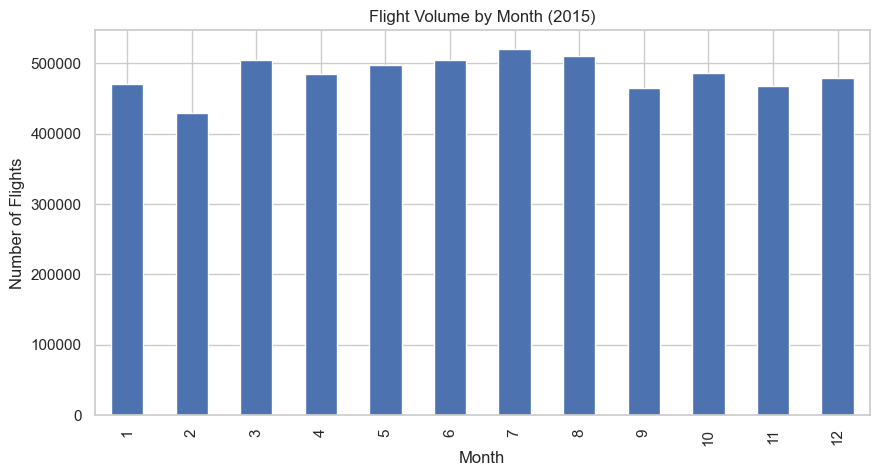


=== Flight volume by DAY_OF_WEEK (2015) ===
DAY_OF_WEEK
1    865543
2    844600
3    855897
4    872521
5    862209
6    700545
7    817764
dtype: int64


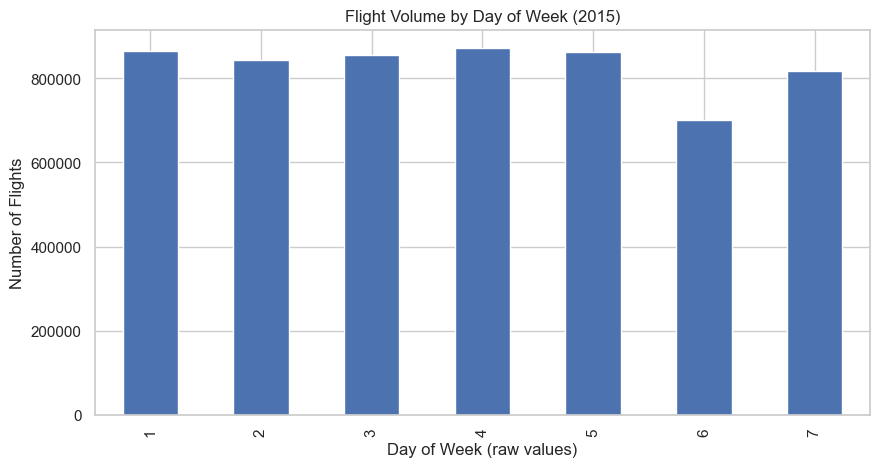

In [30]:
print("\n=== Flight volume by MONTH (2015) ===")
volume_by_month = df2015.groupby('MONTH').size().reindex(range(1,13), fill_value=0)
print(volume_by_month)

ax = volume_by_month.plot(kind='bar')
ax.set_title("Flight Volume by Month (2015)")
ax.set_xlabel("Month")
ax.set_ylabel("Number of Flights")
plt.show()

print("\n=== Flight volume by DAY_OF_WEEK (2015) ===")
# Assuming DAY_OF_WEEK: 1=Monday .. 7=Sunday or 1=Sunday depending on dataset; keep raw labels
volume_by_dow = df2015.groupby('DAY_OF_WEEK').size().sort_index()
print(volume_by_dow)

ax = volume_by_dow.plot(kind='bar')
ax.set_title("Flight Volume by Day of Week (2015)")
ax.set_xlabel("Day of Week (raw values)")
ax.set_ylabel("Number of Flights")
plt.show()

2) % of flights that experienced a departure delay in 2015; avg delay among those


=== Departure delay summary (2015) ===
Total flights that departed (CANCELLED==0): 5,729,195
Number of departures with DEPARTURE_DELAY > 0: 2,123,078
Percentage delayed on departure (of departures): 37.06%
Average departure delay among delayed flights: 32.61 minutes


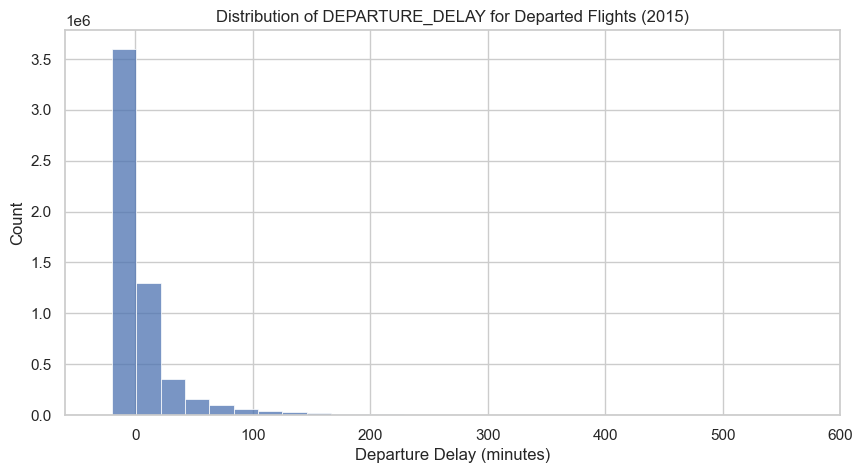

In [32]:
# Define "delayed departure" as DEPARTURE_DELAY > 0 for flights that actually departed (CANCELLED==0)
total_departed = len(departed2015)
delayed_mask = departed2015['DEPARTURE_DELAY'] > 0
num_delayed = delayed_mask.sum()
pct_delayed = 100 * num_delayed / total_departed if total_departed > 0 else np.nan
avg_delay_among_delayed = departed2015.loc[delayed_mask,'DEPARTURE_DELAY'].mean()

print("\n=== Departure delay summary (2015) ===")
print(f"Total flights that departed (CANCELLED==0): {total_departed:,}")
print(f"Number of departures with DEPARTURE_DELAY > 0: {num_delayed:,}")
print(f"Percentage delayed on departure (of departures): {pct_delayed:.2f}%")
print(f"Average departure delay among delayed flights: {avg_delay_among_delayed:.2f} minutes")

# Show distribution of departure delays (optional histogram)
plt.figure()
sns.histplot(departed2015['DEPARTURE_DELAY'].dropna(), bins=100, kde=False)
plt.xlim(-60, 600)   # zoom to sensible range
plt.title("Distribution of DEPARTURE_DELAY for Departed Flights (2015)")
plt.xlabel("Departure Delay (minutes)")
plt.ylabel("Count")
plt.show()

3) How does the % of delayed flights vary throughout the year?


=== Monthly % of delayed departures (2015) ===
        total  delayed  pct_delayed
MONTH                              
1      457986   176419    38.520610
2      408674   173094    42.355031
3      493310   193564    39.237802
4      480631   167124    34.771790
5      491299   178607    36.354033
6      494777   215063    43.466653
7      515912   209425    40.593163
8      505484   190631    37.712569
9      462871   132517    28.629359
10     483711   145042    29.985260
11     463373   152526    32.916463
12     471167   189066    40.127174


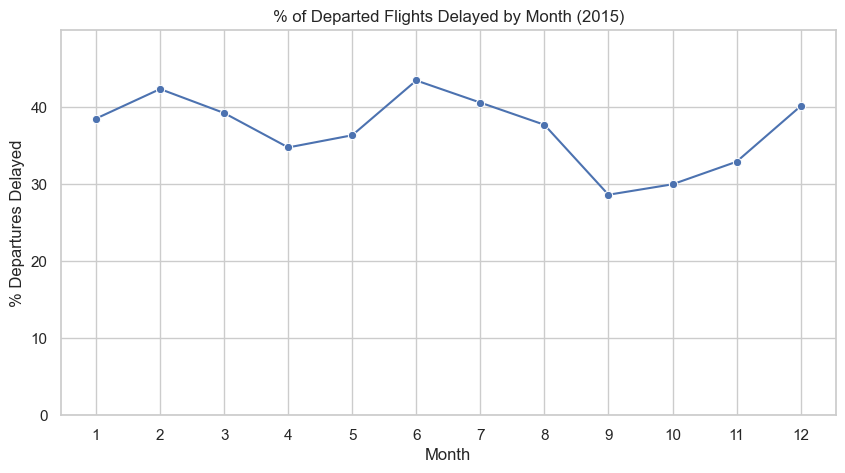

In [33]:
# For each month compute % of departed flights whose DEPARTURE_DELAY > 0
monthly = departed2015.groupby('MONTH').agg(
    total=('DEPARTURE_DELAY','count'),
    delayed=('DEPARTURE_DELAY', lambda s: (s>0).sum())
).reindex(range(1,13), fill_value=0)

monthly['pct_delayed'] = 100 * monthly['delayed'] / monthly['total']
print("\n=== Monthly % of delayed departures (2015) ===")
print(monthly[['total','delayed','pct_delayed']])

plt.figure()
sns.lineplot(x=monthly.index, y=monthly['pct_delayed'], marker='o')
plt.xticks(range(1,13))
plt.title("% of Departed Flights Delayed by Month (2015)")
plt.xlabel("Month")
plt.ylabel("% Departures Delayed")
plt.ylim(0, monthly['pct_delayed'].max() * 1.15)
plt.show()

4) How many flights were cancelled in 2015? What % of cancellations were due to weather? Airline/Carrier?


=== Cancellations (2015) ===
Total cancelled flights: 89,884

Cancellation reason counts (2015):
CANCELLATION_REASON
B    48851
A    25262
C    15749
D       22
Name: count, dtype: int64

Cancellation reason % (2015):
CANCELLATION_REASON
B    54.35
A    28.11
C    17.52
D     0.02
Name: count, dtype: float64

% of cancellations due to Weather (code 'B'): 54.35%
% of cancellations due to Airline/Carrier (code 'A'): 28.11%


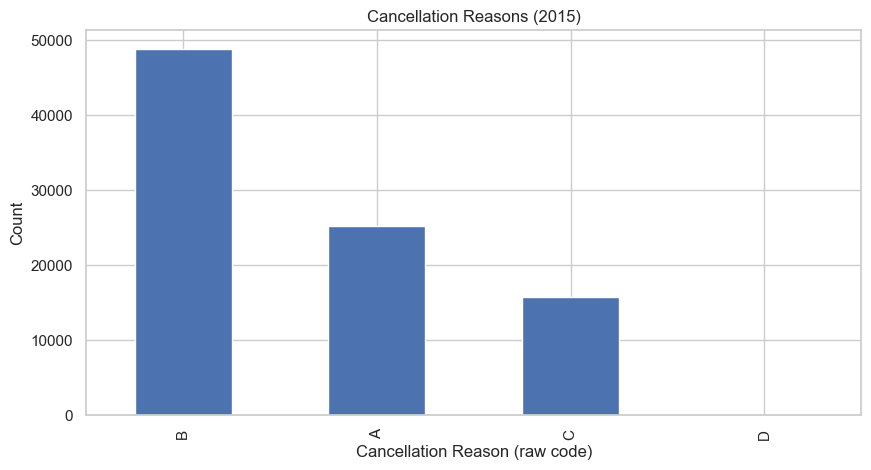

In [34]:
cancellations = df2015[df2015['CANCELLED'] == 1].copy()
total_cancelled = len(cancellations)
print(f"\n=== Cancellations (2015) ===\nTotal cancelled flights: {total_cancelled:,}")

# Count by reason (note: many rows may have NaN in CANCELLATION_REASON for non-cancelled; here we filtered cancelled)
cancel_reason_counts = cancellations['CANCELLATION_REASON'].fillna('Unknown').value_counts()
print("\nCancellation reason counts (2015):")
print(cancel_reason_counts)

# Percent breakdown
cancel_reason_pct = 100 * cancel_reason_counts / cancel_reason_counts.sum()
print("\nCancellation reason % (2015):")
print(cancel_reason_pct.round(2))

# If dataset uses codes like 'B' = Weather and 'A' = Carrier (common convention), compute directly:
# But we will compute percent for 'B' and 'A' regardless of mapping — user can confirm mapping if needed.
pct_weather = 100 * cancel_reason_counts.get('B', 0) / total_cancelled if total_cancelled>0 else np.nan
pct_airline = 100 * cancel_reason_counts.get('A', 0) / total_cancelled if total_cancelled>0 else np.nan

print(f"\n% of cancellations due to Weather (code 'B'): {pct_weather:.2f}%")
print(f"% of cancellations due to Airline/Carrier (code 'A'): {pct_airline:.2f}%")

# Plot cancellation reasons
plt.figure()
cancel_reason_counts.plot(kind='bar')
plt.title("Cancellation Reasons (2015)")
plt.xlabel("Cancellation Reason (raw code)")
plt.ylabel("Count")
plt.show()


5) Which airlines seem most and least reliable in terms of on-time departure?


=== Airline on-time departure performance (2015) ===
         total_flights  on_time_count  on_time_pct
AIRLINE                                           
AS              171852         128311        74.66
HA               76101          55961        73.54
OO              578393         407212        70.40
EV              556746         387243        69.55
US              194648         132196        67.92
DL              872057         589672        67.62
MQ              279607         186375        66.66
AA              715065         469515        65.66
VX               61369          38003        61.93
F9               90248          55389        61.37
B6              262772         160760        61.18
NK              115375          63342        54.90
WN             1245812         679229        54.52
UA              509150         252909        49.67

Top 5 most reliable airlines (by on-time departure %, min flights = 200)
         total_flights  on_time_pct
AIRLINE             

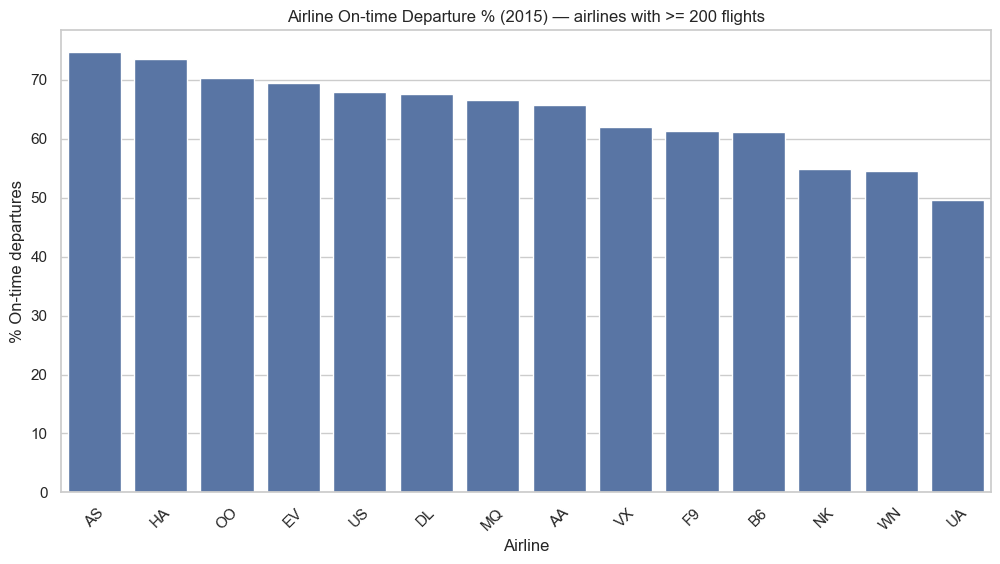

In [35]:
# Define on-time departure as DEPARTURE_DELAY <= 0 and not cancelled.
departed = df2015[df2015['CANCELLED'] == 0].copy()
departed['ON_TIME_DEP'] = (departed['DEPARTURE_DELAY'] <= 0)

airline_perf = departed.groupby('AIRLINE').agg(
    total_flights=('DEPARTURE_DELAY','count'),
    on_time_count=('ON_TIME_DEP','sum')
)
airline_perf['on_time_pct'] = 100 * airline_perf['on_time_count'] / airline_perf['total_flights']
airline_perf = airline_perf.sort_values('on_time_pct', ascending=False)

print("\n=== Airline on-time departure performance (2015) ===")
print(airline_perf[['total_flights','on_time_count','on_time_pct']].round(2))

# Show top 5 most reliable and bottom 5 least reliable (with a minimum flight threshold to avoid tiny-sample noise)
min_flights_threshold = 200  # adjust as needed
filtered = airline_perf[airline_perf['total_flights'] >= min_flights_threshold]

print("\nTop 5 most reliable airlines (by on-time departure %, min flights = {})".format(min_flights_threshold))
print(filtered.head(5)[['total_flights','on_time_pct']].round(2))

print("\nTop 5 least reliable airlines (by on-time departure %, min flights = {})".format(min_flights_threshold))
print(filtered.tail(5)[['total_flights','on_time_pct']].round(2))

# Plot on-time% for airlines (filtered)
plt.figure(figsize=(12,6))
sns.barplot(x=filtered.index, y=filtered['on_time_pct'])
plt.xticks(rotation=45)
plt.title(f"Airline On-time Departure % (2015) — airlines with >= {min_flights_threshold} flights")
plt.ylabel("% On-time departures")
plt.xlabel("Airline")
plt.show()



Univariate Analysis

Numerical Features

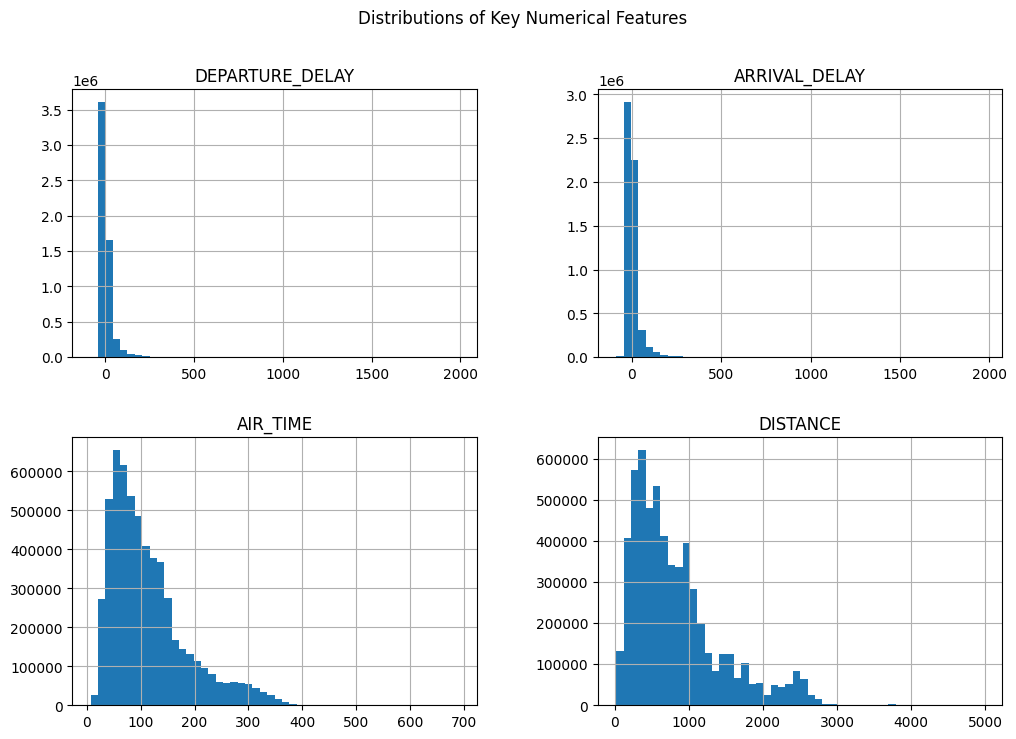

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

df[['DEPARTURE_DELAY','ARRIVAL_DELAY','AIR_TIME','DISTANCE']].hist(
    bins=50, figsize=(12,8))
plt.suptitle("Distributions of Key Numerical Features")
plt.show()


Categorical Features

<Axes: title={'center': 'Top 20 Origin Airports'}, xlabel='ORIGIN_AIRPORT'>

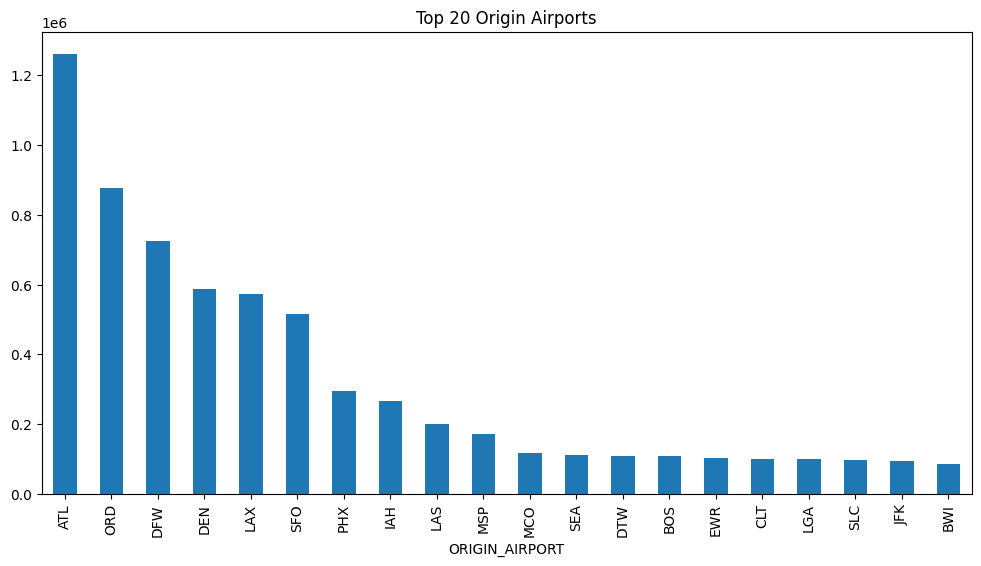

In [7]:
df['AIRLINE'].value_counts().plot(kind='bar', figsize=(10,5), title="Flights per Airline")
df['ORIGIN_AIRPORT'].value_counts().head(20).plot(kind='bar', figsize=(12,6), title="Top 20 Origin Airports")


Bivariate Analysis

Delays by Airline

<Axes: title={'center': 'Average Arrival Delay per Airline'}, xlabel='AIRLINE'>

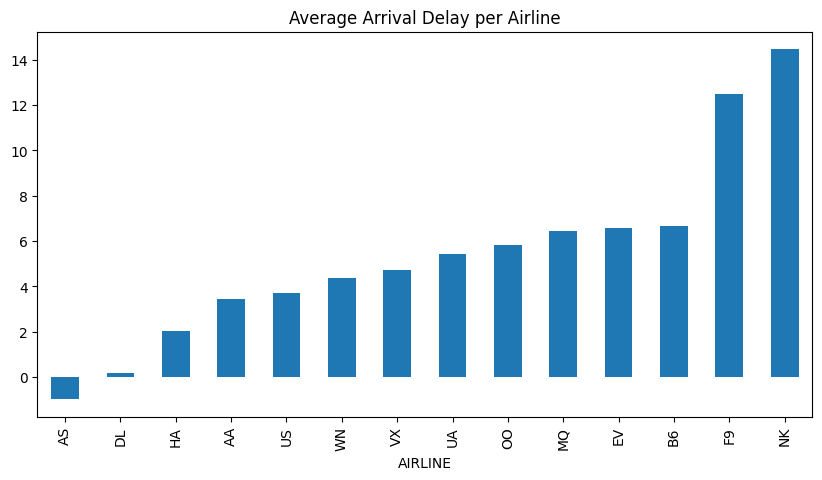

In [8]:
airline_delay = df.groupby('AIRLINE')['ARRIVAL_DELAY'].mean().sort_values()
airline_delay.plot(kind='bar', figsize=(10,5), title="Average Arrival Delay per Airline")


Delays by Day of Week

Text(0.5, 1.0, 'Boxplot of Arrival Delay by Day of Week')

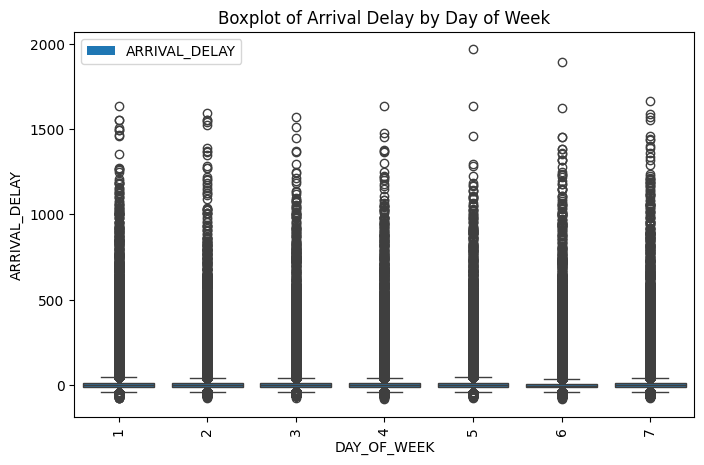

In [9]:
dow_delay = df.groupby('DAY_OF_WEEK')['ARRIVAL_DELAY'].mean()
dow_delay.plot(kind='bar', figsize=(8,5), title="Average Delay by Day of Week")
sns.boxplot(x='DAY_OF_WEEK', y='ARRIVAL_DELAY', data=df)
plt.title("Boxplot of Arrival Delay by Day of Week")

Delays vs Distance

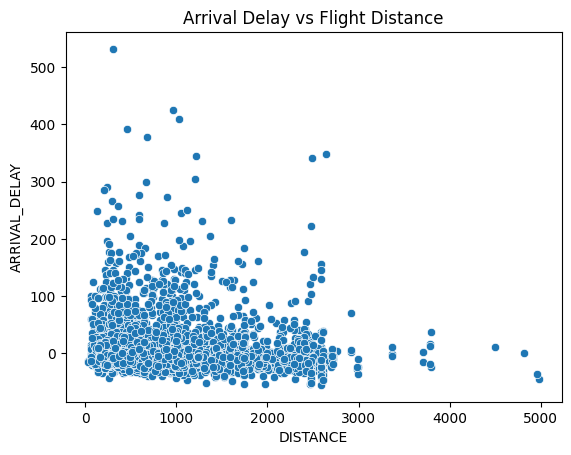

Text(0.5, 1.0, 'Arrival Delay vs Flight Distance by Airline')

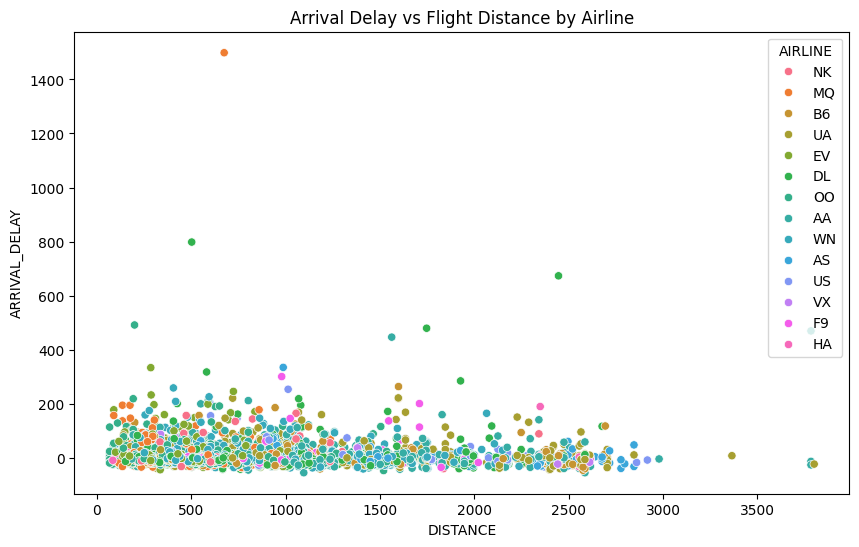

In [10]:
sns.scatterplot(x='DISTANCE', y='ARRIVAL_DELAY', data=df.sample(5000))
plt.title("Arrival Delay vs Flight Distance")
plt.show()
plt.figure(figsize=(10,6))
sns.scatterplot(x='DISTANCE', y='ARRIVAL_DELAY', hue='AIRLINE', data=df.sample(5000))
plt.title("Arrival Delay vs Flight Distance by Airline")

Cancellations & Reasons

Cancellation Rate: 1.54%


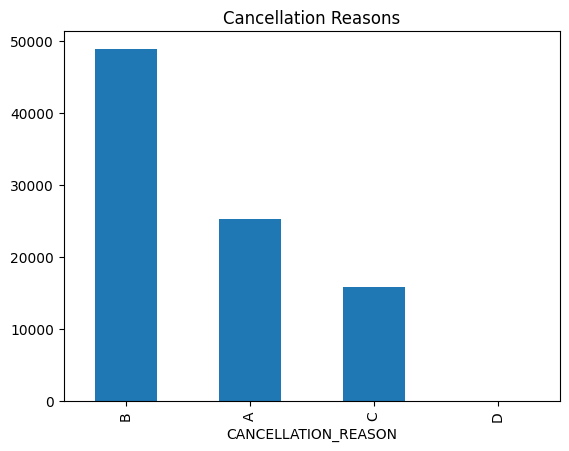

In [11]:
cancel_rate = df['CANCELLED'].mean() * 100
print(f"Cancellation Rate: {cancel_rate:.2f}%")

df['CANCELLATION_REASON'].value_counts().plot(kind='bar', title="Cancellation Reasons")
plt.show()

Delay Components Analysis

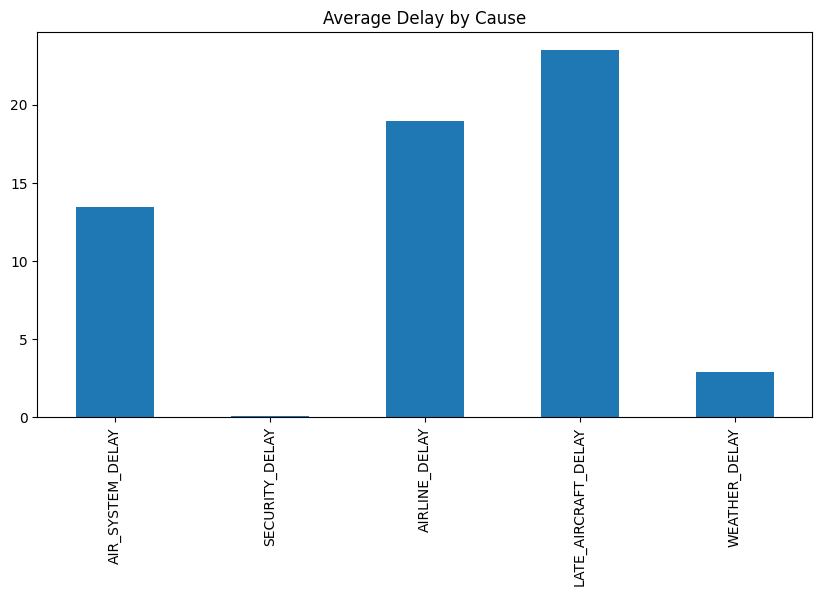

In [12]:
delay_components = ['AIR_SYSTEM_DELAY','SECURITY_DELAY','AIRLINE_DELAY','LATE_AIRCRAFT_DELAY','WEATHER_DELAY']

df[delay_components].mean().plot(kind='bar', figsize=(10,5), title="Average Delay by Cause")
plt.show()

Seasonality (Monthly Trends)

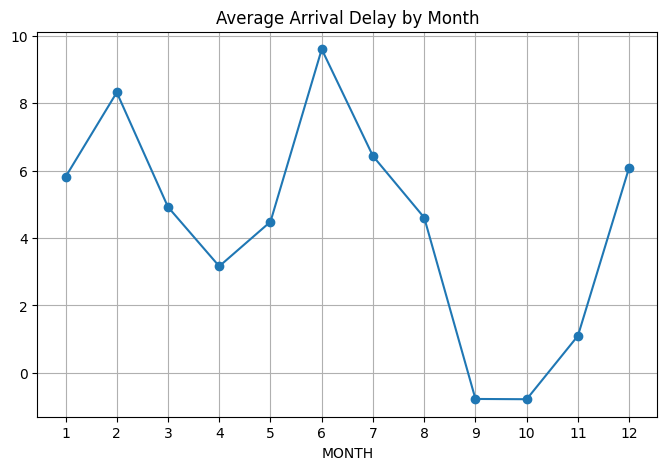

In [13]:
monthly_delay = df.groupby('MONTH')['ARRIVAL_DELAY'].mean()
monthly_delay.plot(marker='o', figsize=(8,5), title="Average Arrival Delay by Month")
plt.xticks(range(1,13))
plt.grid()

Correlation Heatmap

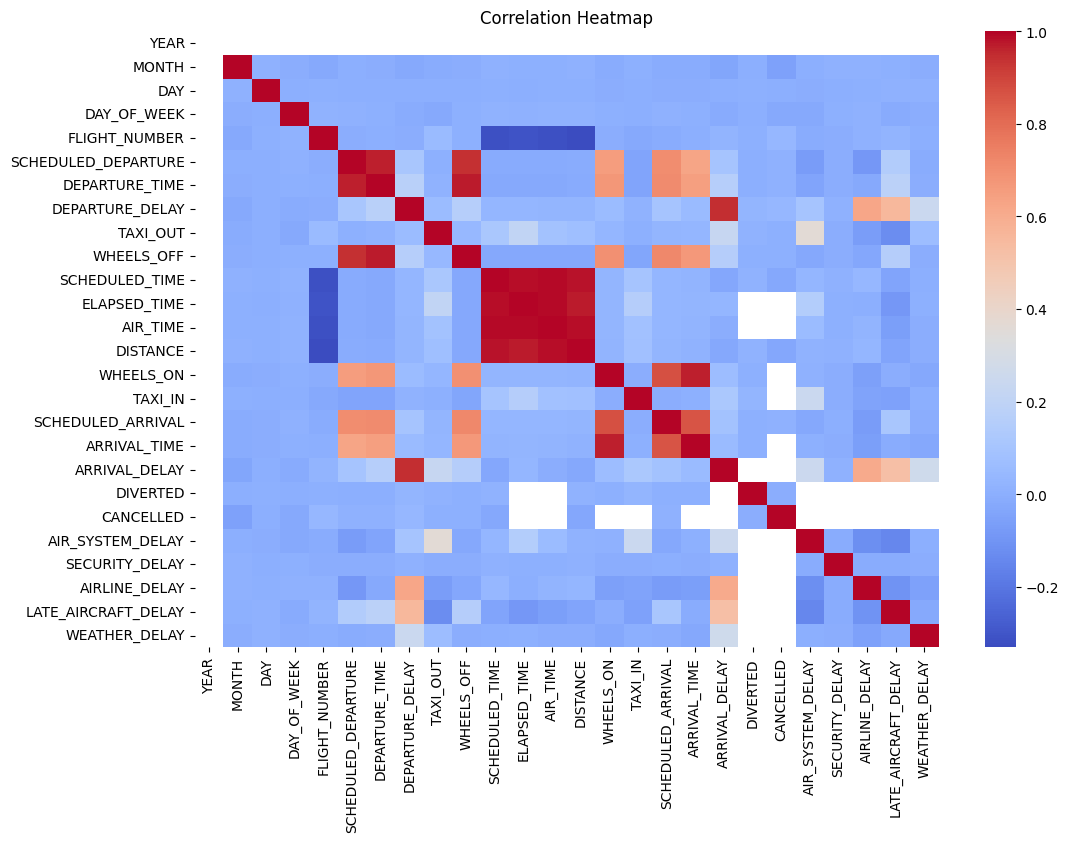

Text(0.5, 0.98, 'Pairplot of Key Numerical Features')

<Figure size 1000x600 with 0 Axes>

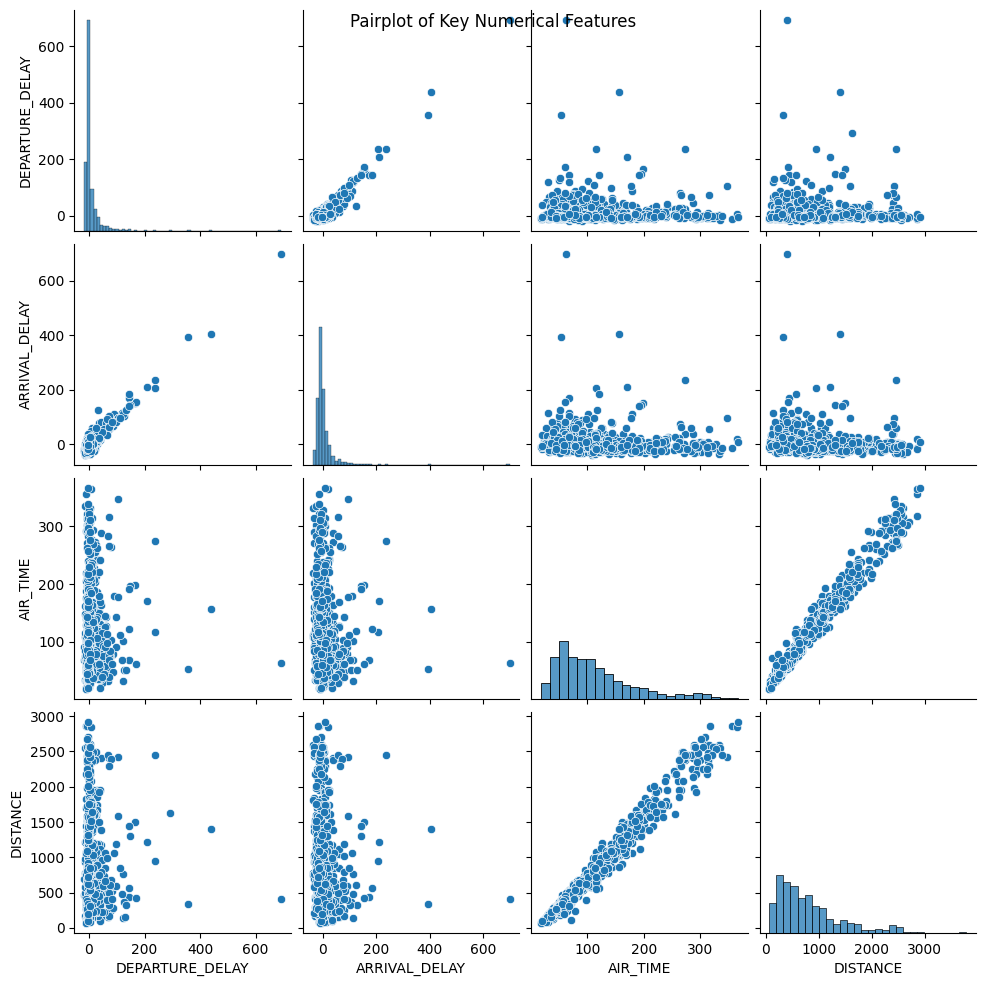

In [14]:
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(numeric_only=True), cmap="coolwarm", annot=False)
plt.title("Correlation Heatmap")
plt.show()
plt.figure(figsize=(10,6))
sns.pairplot(df[['DEPARTURE_DELAY','ARRIVAL_DELAY','AIR_TIME','DISTANCE']].sample(1000))
plt.suptitle("Pairplot of Key Numerical Features")

Outlier Analysis

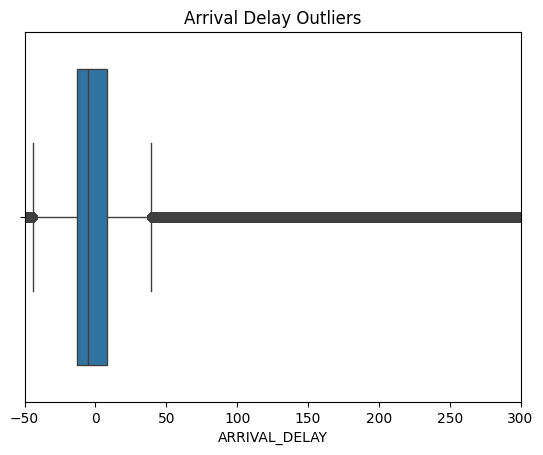

In [15]:
sns.boxplot(x='ARRIVAL_DELAY', data=df)
plt.xlim(-50, 300)  # zoom in, since some flights are extremely delayed
plt.title("Arrival Delay Outliers")
plt.show()


Which airlines have the worst/best delays?

C:\Users\farhan\AppData\Local\Temp\ipykernel_8368\1992875873.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=airline_delay.index, y=airline_delay.values, palette="viridis")


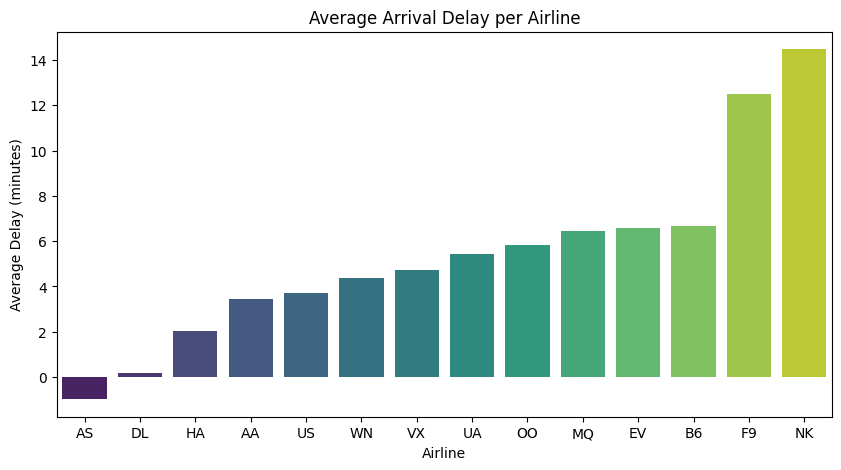

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

airline_delay = df.groupby("AIRLINE")["ARRIVAL_DELAY"].mean().sort_values()

plt.figure(figsize=(10,5))
sns.barplot(x=airline_delay.index, y=airline_delay.values, palette="viridis")
plt.title("Average Arrival Delay per Airline")
plt.ylabel("Average Delay (minutes)")
plt.xlabel("Airline")
plt.show()


Do delays increase in certain months?

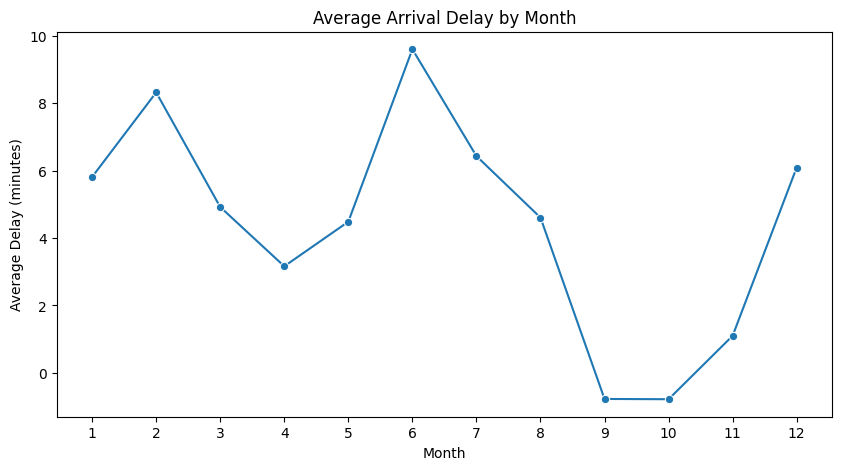

In [17]:
monthly_delay = df.groupby("MONTH")["ARRIVAL_DELAY"].mean()

plt.figure(figsize=(10,5))
sns.lineplot(x=monthly_delay.index, y=monthly_delay.values, marker="o")
plt.title("Average Arrival Delay by Month")
plt.ylabel("Average Delay (minutes)")
plt.xlabel("Month")
plt.xticks(range(1,13))
plt.show()


Do longer flights have more/less delays?

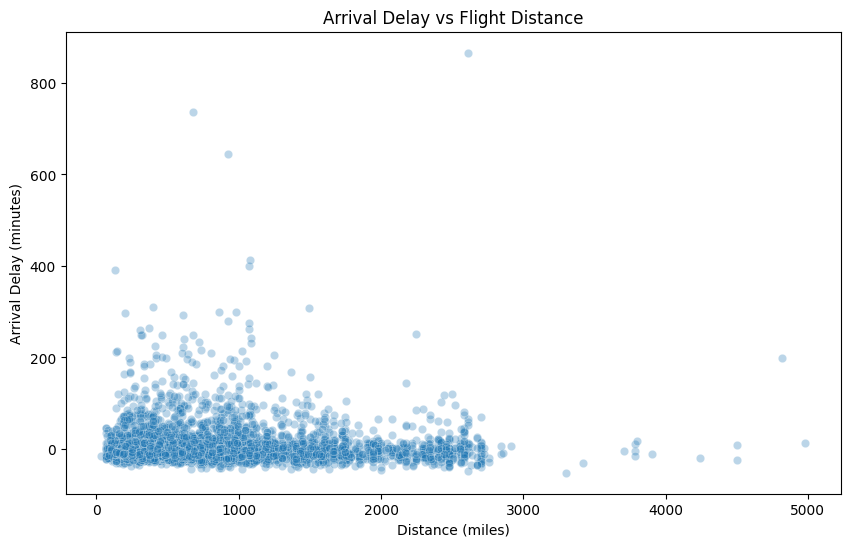

Text(0.5, 1.0, 'Arrival Delay vs Flight Distance by Airline')

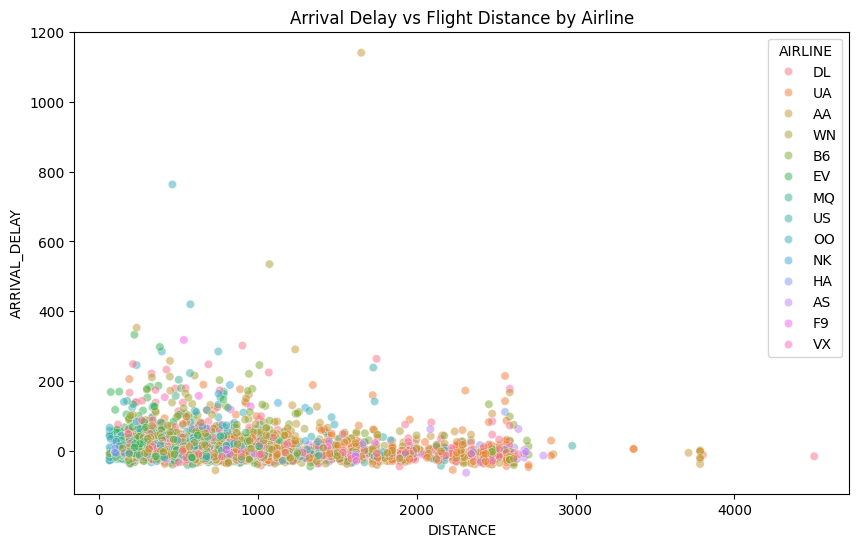

In [18]:
plt.figure(figsize=(10,6))
sns.scatterplot(x="DISTANCE", y="ARRIVAL_DELAY", data=df.sample(5000), alpha=0.3)
plt.title("Arrival Delay vs Flight Distance")
plt.xlabel("Distance (miles)")
plt.ylabel("Arrival Delay (minutes)")
plt.show()
plt.figure(figsize=(10,6))
sns.scatterplot(x="DISTANCE", y="ARRIVAL_DELAY", hue="AIRLINE", data=df.sample(5000), alpha=0.5)
plt.title("Arrival Delay vs Flight Distance by Airline")

Which airports cause the most cancellations?

C:\Users\farhan\AppData\Local\Temp\ipykernel_8368\2833868841.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=airport_cancel.index, y=airport_cancel.values, palette="magma")


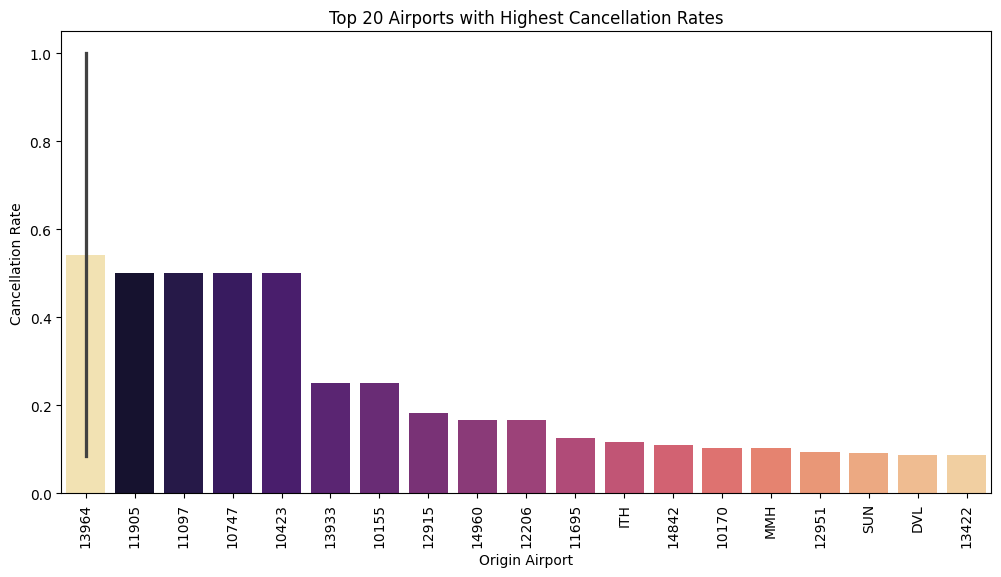

In [19]:
airport_cancel = df.groupby("ORIGIN_AIRPORT")["CANCELLED"].mean().sort_values(ascending=False).head(20)

plt.figure(figsize=(12,6))
sns.barplot(x=airport_cancel.index, y=airport_cancel.values, palette="magma")
plt.title("Top 20 Airports with Highest Cancellation Rates")
plt.ylabel("Cancellation Rate")
plt.xlabel("Origin Airport")
plt.xticks(rotation=90)
plt.show()


Day of Week & Time-of-Day Effects

    Are Mondays worse for delays than weekends?

    Do evening flights get delayed more than morning ones?

Text(0.5, 1.0, 'Average Arrival Delay by Day of Week and Departure Hour')

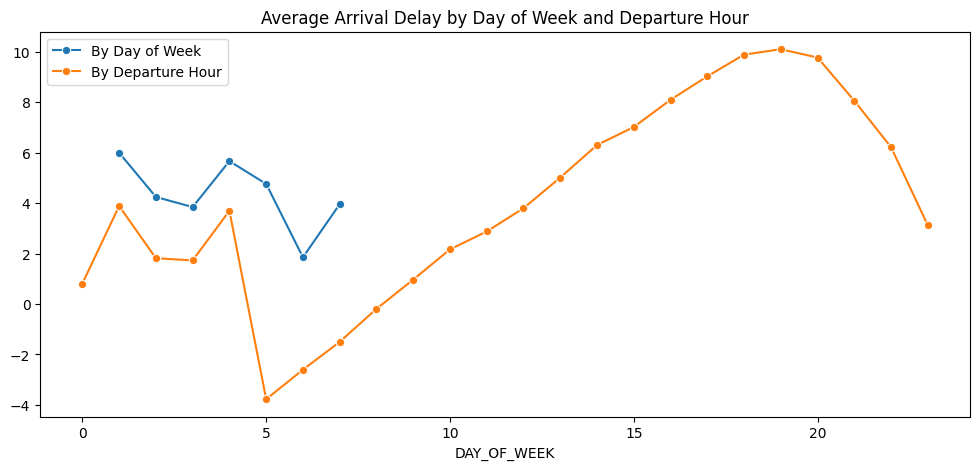

In [21]:
# Delays by day of week
dow_delay = df.groupby("DAY_OF_WEEK")["ARRIVAL_DELAY"].mean()

# Delays by scheduled departure hour
df["DEP_HOUR"] = (df["SCHEDULED_DEPARTURE"] // 100) % 24
hourly_delay = df.groupby("DEP_HOUR")["ARRIVAL_DELAY"].mean()
plt.figure(figsize=(12,5))
sns.lineplot(x=dow_delay.index, y=dow_delay.values, marker="o", label="By Day of Week")
sns.lineplot(x=hourly_delay.index, y=hourly_delay.values, marker="o", label="By Departure Hour")
plt.title("Average Arrival Delay by Day of Week and Departure Hour")

Taxi-Out & Taxi-In Impact
    Long taxi times often correlate with congested airports.
    Compare average taxi-out times by airport.

C:\Users\farhan\AppData\Local\Temp\ipykernel_8368\1331894327.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=taxi_out_airports.index, y=taxi_out_airports.values, palette="coolwarm")


Text(0.5, 1.0, 'Top 15 Airports with Longest Average Taxi-Out Times')

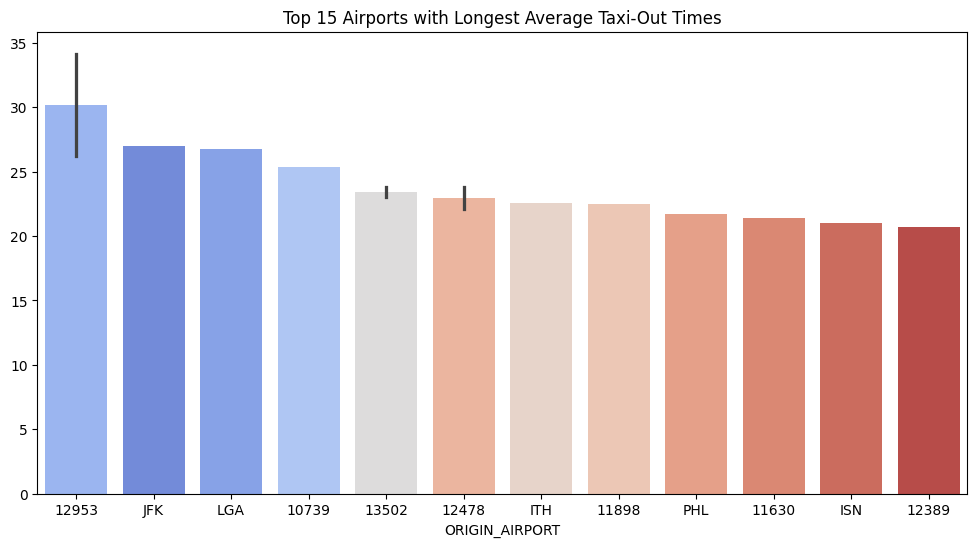

In [22]:
taxi_out_airports = df.groupby("ORIGIN_AIRPORT")["TAXI_OUT"].mean().sort_values(ascending=False).head(15)
plt.figure(figsize=(12,6))
sns.barplot(x=taxi_out_airports.index, y=taxi_out_airports.values, palette="coolwarm")
plt.title("Top 15 Airports with Longest Average Taxi-Out Times")

On-Time Performance

    Create a binary feature: on-time vs delayed.

    Check which airlines/airports have the best on-time percentage.

C:\Users\farhan\AppData\Local\Temp\ipykernel_8368\12083870.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=on_time_airline.index, y=on_time_airline.values, palette="Blues_d")


Text(0.5, 1.0, 'On-Time Performance by Airline')

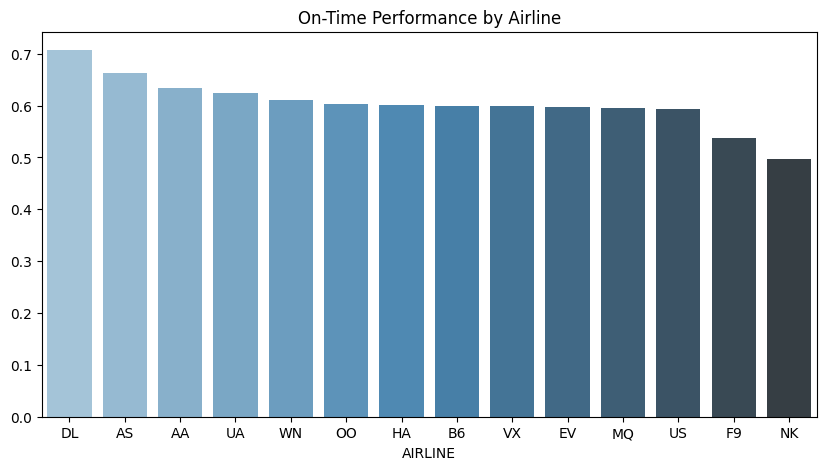

In [23]:
df["ON_TIME"] = df["ARRIVAL_DELAY"] <= 0
on_time_airline = df.groupby("AIRLINE")["ON_TIME"].mean().sort_values(ascending=False)
plt.figure(figsize=(10,5))
sns.barplot(x=on_time_airline.index, y=on_time_airline.values, palette="Blues_d")
plt.title("On-Time Performance by Airline")

Diverted Flights

    Which airports and airlines divert the most flights?

    Any geographic pattern?

C:\Users\farhan\AppData\Local\Temp\ipykernel_8368\4175023776.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=diverted.index, y=diverted.values, palette="Reds_d")


Text(0.5, 1.0, 'Top 15 Airports with Highest Diversion Rates')

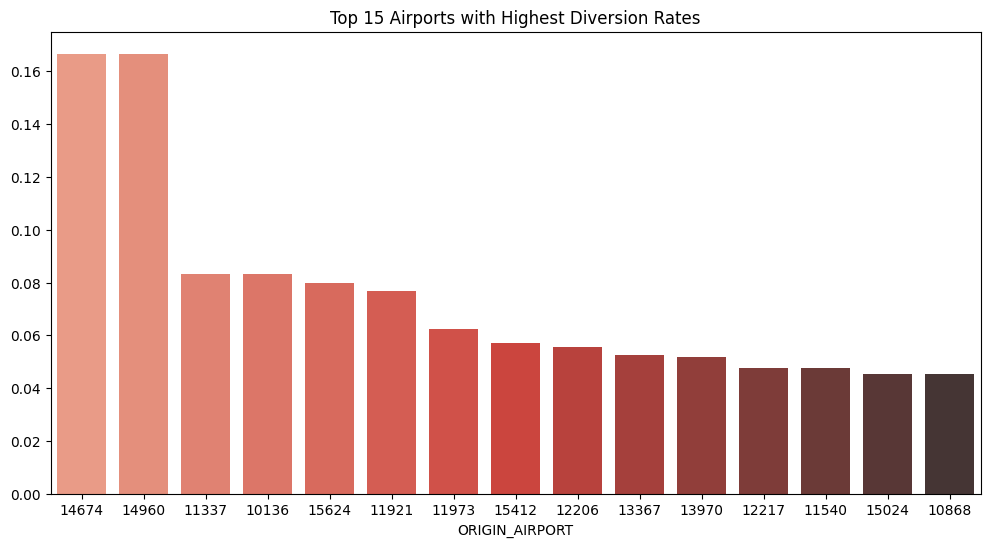

In [24]:
diverted = df.groupby("ORIGIN_AIRPORT")["DIVERTED"].mean().sort_values(ascending=False).head(15)
plt.figure(figsize=(12,6))
sns.barplot(x=diverted.index, y=diverted.values, palette="Reds_d")
plt.title("Top 15 Airports with Highest Diversion Rates")

Cancellation Reasons by Season

    Do weather cancellations spike in winter?

    Do security-related cancellations cluster at specific times?

Text(0.5, 1.0, 'Monthly Cancellation Reasons')

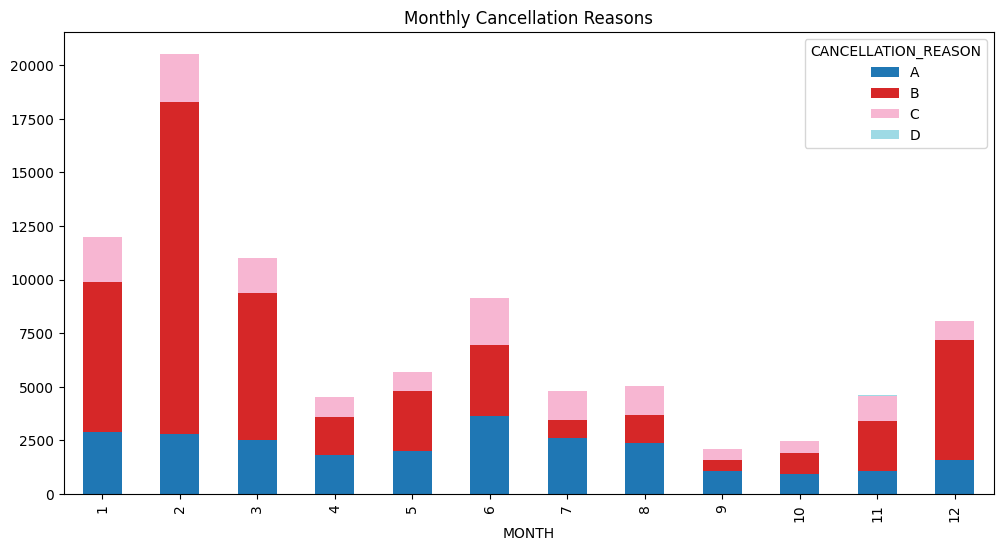

In [25]:
cancel_reason_month = df.groupby(["MONTH","CANCELLATION_REASON"]).size().unstack(fill_value=0)
cancel_reason_month.plot(kind='bar', stacked=True, figsize=(12,6), colormap='tab20')
plt.title("Monthly Cancellation Reasons")

Delay Duration Categories

    Categorize delays into buckets:

        On-time (<=0)
        Short (1–15 min)
        Medium (16–60 min)
        Severe (>60 min)

Text(0, 0.5, 'Proportion')

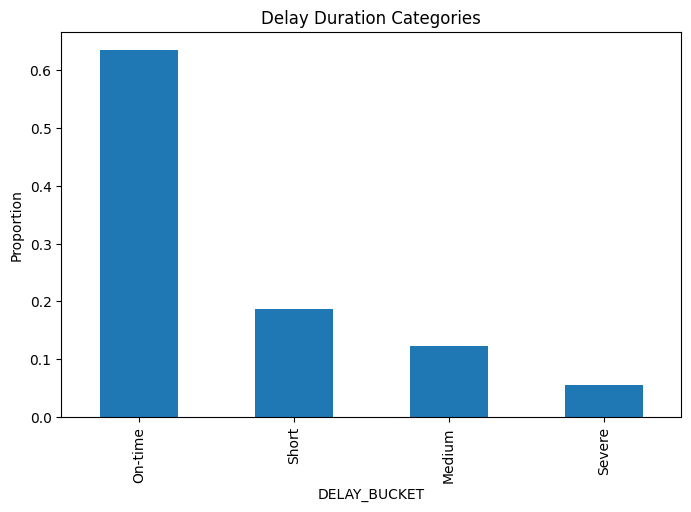

In [26]:
df["DELAY_BUCKET"] = pd.cut(df["ARRIVAL_DELAY"], bins=[-999,0,15,60,9999],
                            labels=["On-time","Short","Medium","Severe"])
delay_bucket_dist = df["DELAY_BUCKET"].value_counts(normalize=True)
delay_bucket_dist.plot(kind='bar', figsize=(8,5), title="Delay Duration Categories")
plt.ylabel("Proportion")

Route Analysis

    Which routes (origin–destination pairs) have the highest average delays?

    Which ones are most reliable?

<Axes: xlabel='ORIGIN_AIRPORT,DESTINATION_AIRPORT'>

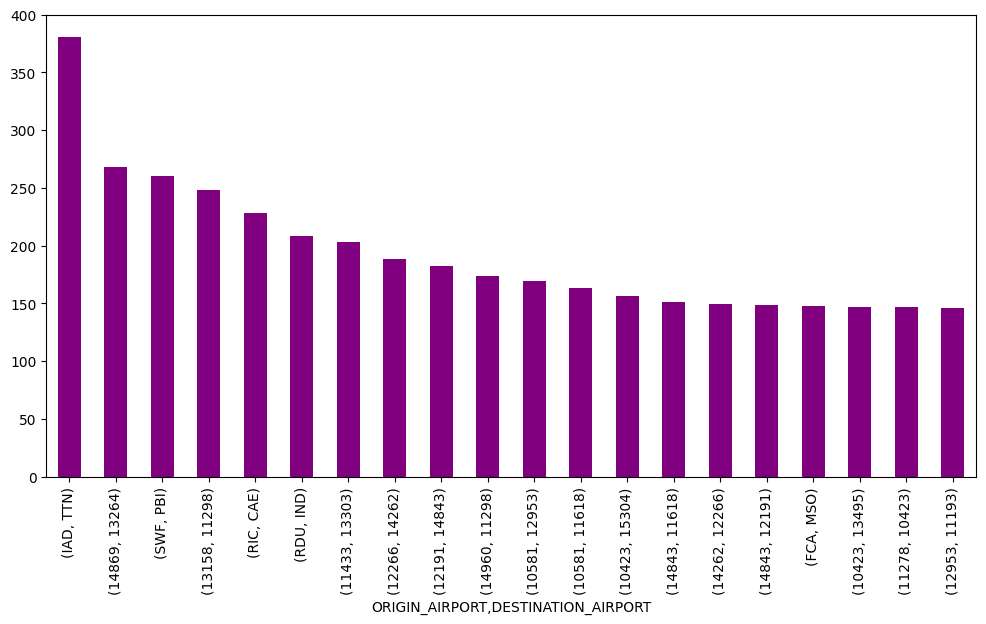

In [27]:
route_delay = df.groupby(["ORIGIN_AIRPORT","DESTINATION_AIRPORT"])["ARRIVAL_DELAY"].mean().sort_values(ascending=False).head(20)
plt.figure(figsize=(12,6))
route_delay.plot(kind='bar', color='purple')    

Distance vs Air Time Consistency

    Plot expected vs actual air time.

    Check if longer flights deviate more from schedule.

Text(0.5, 0, 'Distance (miles)')

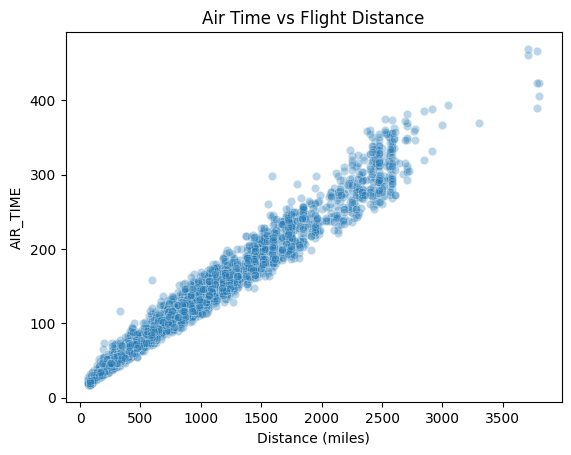

In [28]:
sns.scatterplot(x="DISTANCE", y="AIR_TIME", data=df.sample(5000), alpha=0.3)
plt.title("Air Time vs Flight Distance")
plt.xlabel("Distance (miles)")